# Oficina 4 – Transações em Banco de Dados

Integrantes:
* André Luiz Girão Ferreira
* Sara
* Thaís
* Tiago

**Objetivo**: Experimentar estratégias para utilização de transações e níveis de isolamento em SGBDs relacionais. As tarefas envolvem uma simulação de um sistema de reservas de passagem áreas.








## Informações Iniciais - Simulação de Sistema de Reservas de Passagens

### Tabela e Atributos

Considere a seguinte tabela que registra os assentos reservados em um vôo:

***Assentos(num_voo,disp)***
onde

* ***num_voo***: é um número inteiro de 1 a 200
* ***disp***: é um atributo booleano cujo valor é **true** se o assento estiver vago e **false** caso contrário. **O valor inicial é *true***

### Reserva de Assento

A reserva de um assento é feita em três passos:

* **Passo 1:** O sistema recupera a lista dos assentos disponíveis.
* **Passo 2:** O cliente escolhe o assento. Esse passo deve ser simulado pela escolha aleatória de um dos assentos disponíveis, levando para isso um **tempo de escolha de 1 segundo**.
* **Passo 3:** O sistema registra a reserva do assento escolhido, **atualizando o valor de disp para false**.

Cada assento é reservado individualmente. Duas versões diferentes do processo de reserva devem ser implementadas:
* **Versão A:** A reserva é implementada como uma única transação que inclui os três passos acima.
* **Versão B:** A reserva inclui uma transação para o Passo 1 e outra para o Passo 3. O Passo 2 não faz parte das transações, mas deve ser executado.

### Os Agentes

Agentes de viagens são responsáveis por realizar as reservas de **200 clientes no total**. A atividade de um agente de viagens é simulada por uma ***thread***.

Experimentos devem ser realizados simulando a atuação de **k** agentes de viagem trabalhando simultaneamente, onde
* k = 1,2,4,6,8 e 10.

Cada agente/thread faz uma reserva de cada vez. **As threads devem ser reiniciadas até que todos os 200 clientes tenham seus assentos reservados**.

### Sobre os Experimentos

Dois conjuntos de experimentos devem ser feitos usando dois níveis de isolamento:  
* “read committed”; e
* “serializable”.  

Nos dois casos, o sistema deve ser configurado para **realizar bloqueios a nível de tupla** (linha).


### Preparação Inicial do Banco de Dados 

In [19]:
#instalando dependências
!pip install psycopg2 pandas numpy matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 6.1 MB/s eta 0:00:02
   ---------------------------- ----------- 5.8/8.1 MB 17.0 MB/s eta 0:00:01
   -------------------------------------- - 7.9/8.1 MB 18.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 13.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 20.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 17.0 MB/s eta 0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- -------------------------------

In [23]:
# importando dependências
import threading
import random
import time
import psycopg2
from psycopg2 import errors # Para capturar erros específicos como deadlock
import psycopg2.extensions # Para os níveis de isolamento
import pandas as pd # Usar pandas para tabelas
import numpy as np # Para cálculos de média, min, max
import matplotlib.pyplot as plt

In [3]:
# --- Configurações do Banco de Dados ---
DB_CONFIG_ADMIN = {
    'host': 'localhost',
    'port': '5432',
    'dbname': 'postgres',
    'user': 'postgres',
    'password': '1234',
    'options': '-c client_encoding=UTF8'
}

DB_CONFIG_OFICINA4 = {
    'host': 'localhost',
    'port': '5432',
    'dbname': 'oficina4',
    'user': 'postgres',
    'password': '1234',
    'options': '-c client_encoding=UTF8'
}

In [4]:
# --- Funções de Conexão e Configuração do Banco ---
def get_conexao_db(db_config, isolation_level=None):
    """
    Estabelece uma conexão com o banco de dados PostgreSQL usando as configurações fornecidas
    e define o nível de isolamento da transação, se especificado.
    """
    conn = psycopg2.connect(**db_config)
    # Autocommit é definido como False por padrão para transações explícitas
    conn.autocommit = False 
    if isolation_level:
        # Define o nível de isolamento da transação
        if isolation_level.lower() == "read committed":
            conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_READ_COMMITTED)
        elif isolation_level.lower() == "serializable":
            conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_SERIALIZABLE)
        else:
            raise ValueError(f"Nível de isolamento '{isolation_level}' não suportado. Use 'read committed' ou 'serializable'.")
    return conn


In [5]:
def criar_banco_oficina4():
    """
    Cria o banco de dados 'oficina4' se ele ainda não existir.
    Conecta-se ao banco de dados administrativo ('postgres') para realizar esta operação.
    """
    conn_admin = None
    try:
        conn_admin = get_conexao_db(DB_CONFIG_ADMIN)
        # Para CREATE DATABASE, autocommit DEVE ser True
        conn_admin.autocommit = True 
        cur_admin = conn_admin.cursor()

        cur_admin.execute("SELECT 1 FROM pg_database WHERE datname = 'oficina4'")
        existe = cur_admin.fetchone()
        if not existe:
            cur_admin.execute("CREATE DATABASE oficina4 WITH ENCODING 'UTF8' LC_COLLATE 'C' LC_CTYPE 'C' TEMPLATE template0;")
            print("Banco de dados 'oficina4' criado com sucesso.")
        else:
            print("Banco de dados 'oficina4' já existe.")
        cur_admin.close()
    except psycopg2.Error as e:
        print(f"Erro ao criar o banco de dados 'oficina4': {e}")
        return False
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao criar o banco: {e}")
        return False
    finally:
        if conn_admin is not None:
            conn_admin.close()
    return True

In [6]:
def criar_tabela_assentos():
    """
    Cria a tabela 'Assentos' no banco de dados 'oficina4' se ela ainda não existir.
    Conecta-se diretamente ao banco de dados 'oficina4' para realizar esta operação.
    """
    conn_oficina4 = None
    try:
        print("Tentando conectar ao banco de dados 'oficina4' para criar a tabela...")
        # Para CREATE TABLE, autocommit DEVE ser True
        conn_oficina4 = get_conexao_db(DB_CONFIG_OFICINA4)
        conn_oficina4.autocommit = True
        cur_oficina4 = conn_oficina4.cursor()

        cur_oficina4.execute("""
            CREATE TABLE IF NOT EXISTS Assentos (
                num_voo INTEGER PRIMARY KEY CHECK (num_voo BETWEEN 1 AND 200),
                disp BOOLEAN DEFAULT TRUE
            );
        """)
        print("Tabela 'Assentos' criada com sucesso.")
        cur_oficina4.close()
    except psycopg2.Error as e:
        print(f"Erro ao criar a tabela 'Assentos': {e}")
        return False
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao criar a tabela: {e}")
        return False
    finally:
        if conn_oficina4 is not None:
            conn_oficina4.close()
    return True


In [7]:
def inicializar_assentos():
    """
    Inicializa a tabela 'Assentos', limpando todos os dados existentes
    e inserindo 200 assentos, todos definidos como 'disp = TRUE'.
    Esta função deve ser rodada uma única vez para configurar a tabela.
    """
    conn = None
    cur = None
    try:
        conn = get_conexao_db(DB_CONFIG_OFICINA4)
        conn.autocommit = False # Transação para DELETE e INSERT
        cur = conn.cursor()

        cur.execute("DELETE FROM Assentos;")
        print("Tabela 'Assentos' limpa para inicialização.")

        for i in range(1, 201):
            cur.execute("INSERT INTO Assentos (num_voo, disp) VALUES (%s, TRUE);", (i,))
        
        conn.commit()
        print("200 assentos inicializados como TRUE com sucesso.")
    except psycopg2.Error as e:
        print(f"Erro ao inicializar assentos: {e}")
        if conn:
            conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao inicializar assentos: {e}")
        if conn:
            conn.rollback()
    finally:
        if cur: cur.close()
        if conn: conn.close()

def limpar_assentos():
    """
    Define o status de 'disp' para TRUE para todos os assentos na tabela 'Assentos'.
    Útil para resetar o estado dos assentos entre testes.
    """
    conn = None
    cur = None
    try:
        conn = get_conexao_db(DB_CONFIG_OFICINA4)
        conn.autocommit = False # Transação para UPDATE
        cur = conn.cursor()

        cur.execute("UPDATE Assentos SET disp = TRUE;")
        
        conn.commit()
        print("Todos os assentos foram limpos (definidos como TRUE).")
    except psycopg2.Error as e:
        print(f"Erro ao limpar assentos: {e}")
        if conn:
            conn.rollback()
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao limpar assentos: {e}")
        if conn:
            conn.rollback()
    finally:
        if cur: cur.close()
        if conn: conn.close()


In [8]:
# --- Configuração Inicial do Ambiente ---
print("--- Verificando e configurando o ambiente do banco de dados ---")
if criar_banco_oficina4():
    if criar_tabela_assentos():
        inicializar_assentos() # Popula a tabela com 200 assentos
    else:
        print("Não foi possível criar a tabela 'Assentos'. Abortando testes.")
        exit()
else:
    print("Não foi possível criar o banco de dados 'oficina4'. Abortando testes.")
    exit()

--- Verificando e configurando o ambiente do banco de dados ---
Banco de dados 'oficina4' criado com sucesso.
Tentando conectar ao banco de dados 'oficina4' para criar a tabela...
Tabela 'Assentos' criada com sucesso.
Tabela 'Assentos' limpa para inicialização.
200 assentos inicializados como TRUE com sucesso.


### Tarefa 1

Implemente as **versões A e B do processo de reserva**. É importante que as implementações tratem adequadamente conflitos de Concorrência como **deadlocks e rollbacks**


In [9]:
# --- Variáveis Globais para Coleta de Métricas ---
# Usamos Locks para proteger o acesso a essas variáveis compartilhadas entre threads
metrics_lock = threading.Lock()
total_deadlocks = 0
total_rollbacks = 0
# Lista para armazenar o número de tentativas por reserva bem-sucedida
all_attempts_per_reservation = [] 

# Listas para armazenar os resultados dos experimentos
results_tempo = []
results_tentativas = []
results_conflitos = []
results_ordem_assentos = [] # Para armazenar as ordens finais dos assentos

k_values = [1, 2, 4, 6, 8, 10]
isolation_levels = ["read committed", "serializable"]
versions = ["A", "B"]

In [10]:
# --- Funções de Reserva de Assentos ---
def reservar_assento_versao_a(id_agente, stop_event, isolation_level):
    """
    Tenta reservar um assento em uma única transação, usando FOR UPDATE para bloqueio.
    Continua tentando até que o evento de parada seja sinalizado.
    Recebe o nível de isolamento para a transação.
    """
    global total_deadlocks, total_rollbacks, all_attempts_per_reservation
    attempts = 0
    while not stop_event.is_set():
        conn = None
        cur = None
        attempts += 1 # Conta cada tentativa de reserva
        try:
            conn = get_conexao_db(DB_CONFIG_OFICINA4, isolation_level=isolation_level)
            cur = conn.cursor()
            # conn.autocommit = False já é o padrão em get_conexao_db

            cur.execute("SELECT num_voo FROM Assentos WHERE disp = TRUE ORDER BY num_voo ASC FOR UPDATE;")
            disponiveis = cur.fetchall()

            if not disponiveis:
                print(f"[Agente-{id_agente}]: Nenhum assento disponível. Sinalizando parada.")
                conn.rollback()
                stop_event.set()
                break

            time.sleep(1) # Simula o tempo de duração da reserva
            escolhido = random.choice(disponiveis)[0]

            cur.execute("UPDATE Assentos SET disp = FALSE WHERE num_voo = %s;", (escolhido,))
            
            if cur.rowcount == 0:
                print(f"[Agente-{id_agente}]: Assento {escolhido} não foi atualizado (já reservado por outro?). Retentando...")
                conn.rollback()
                with metrics_lock:
                    total_rollbacks += 1 # Conta rollback por falha na atualização
            else:
                conn.commit()
                print(f"[Agente-{id_agente}]: Reservado assento {escolhido} (Tentativas: {attempts})")
                with metrics_lock:
                    all_attempts_per_reservation.append(attempts) # Registra tentativas
                attempts = 0 # Reseta tentativas para a próxima reserva
                # Não quebra o loop, o agente continua tentando reservar outro assento
                # até que stop_event seja setado por falta de assentos.

        except errors.DeadlockDetected as e:
            print(f"[Agente-{id_agente}]: Deadlock detectado! Rollback e retentando. Erro: {e}")
            if conn: conn.rollback()
            with metrics_lock:
                total_deadlocks += 1
                total_rollbacks += 1 # Deadlock sempre implica um rollback
        except psycopg2.Error as e:
            print(f"[Agente-{id_agente}]: Erro no DB: {e}. Rollback e retentando...")
            if conn: conn.rollback()
            with metrics_lock:
                total_rollbacks += 1
        except Exception as e:
            print(f"[Agente-{id_agente}]: Erro inesperado: {e}. Sinalizando parada.")
            if conn: conn.rollback()
            stop_event.set()
            break
        finally:
            if cur: cur.close()
            if conn: conn.close()
        time.sleep(0.01) # Pequeno delay para evitar busy-waiting


In [11]:
def reservar_assento_versao_b(id_agente, stop_event, isolation_level):
    """
    Tenta reservar um assento em duas transações separadas (seleção e atualização).
    Usa um UPDATE condicional para garantir atomicidade na reserva.
    Continua tentando até que o evento de parada seja sinalizado.
    Recebe o nível de isolamento para a transação.
    """
    global total_deadlocks, total_rollbacks, all_attempts_per_reservation
    attempts = 0
    while not stop_event.is_set():
        conn = None
        cur1 = None
        cur2 = None
        attempts += 1 # Conta cada tentativa de reserva
        try:
            conn = get_conexao_db(DB_CONFIG_OFICINA4, isolation_level=isolation_level)
            # conn.autocommit = False já é o padrão em get_conexao_db

            # Transação 1: buscar assentos disponíveis (sem bloqueio)
            cur1 = conn.cursor()
            cur1.execute("SELECT num_voo FROM Assentos WHERE disp = TRUE ORDER BY num_voo ASC;")
            disponiveis = cur1.fetchall()

            if not disponiveis:
                print(f"[Agente-{id_agente}]: Nenhum assento disponível. Sinalizando parada.")
                conn.rollback() # Garante que a transação 1 seja desfeita (se houve alguma alteração)
                stop_event.set()
                break

            conn.commit() # Fecha a transação 1, liberando o cursor1
            cur1.close()
            
            time.sleep(1) # Simula o tempo de duração da reserva
            escolhido = random.choice(disponiveis)[0]

            # Transação 2: Tentativa de reserva (usa o estado atual do DB)
            cur2 = conn.cursor()
            cur2.execute("UPDATE Assentos SET disp = FALSE WHERE num_voo = %s AND disp = TRUE;", (escolhido,))
            
            if cur2.rowcount == 0:
                print(f"[Agente-{id_agente}]: Assento {escolhido} já foi reservado por outro agente ou não existe mais. Retentando...")
                conn.rollback() # Não conseguiu reservar, faz rollback da transação 2
                with metrics_lock:
                    total_rollbacks += 1 # Conta rollback por falha na atualização
            else:
                conn.commit()
                print(f"[Agente-{id_agente}]: Reservado assento {escolhido} (Tentativas: {attempts})")
                with metrics_lock:
                    all_attempts_per_reservation.append(attempts) # Registra tentativas
                attempts = 0 # Reseta tentativas para a próxima reserva
                # Não quebra o loop, o agente continua tentando reservar outro assento

        except errors.DeadlockDetected as e:
            print(f"[Agente-{id_agente}]: Deadlock detectado! Rollback e retentando. Erro: {e}")
            if conn: conn.rollback()
            with metrics_lock:
                total_deadlocks += 1
                total_rollbacks += 1
        except psycopg2.Error as e:
            print(f"[Agente-{id_agente}]: Erro no DB: {e}. Rollback e retentando...")
            if conn: conn.rollback()
            with metrics_lock:
                total_rollbacks += 1
        except Exception as e:
            print(f"[Agente-{id_agente}]: Erro inesperado: {e}. Sinalizando parada.")
            if conn: conn.rollback()
            stop_event.set()
            break
        finally:
            if 'cur1' in locals() and cur1 and not cur1.closed: cur1.close()
            if 'cur2' in locals() and cur2 and not cur2.closed: cur2.close()
            if conn: conn.close()
        time.sleep(0.01)


### Tarefa 2

Apresente gráficos de linha onde, para cada valor de k (número de agentes) no eixo x, temos no eixo y o tempo necessário para que todos os clientes efetuem suas reservas. Um gráfico diferente deve ser apresentado para cada par de versões da reserva e nível de isolamento.



In [12]:
# --- Gerenciador de Threads para Experimentos de Reserva ---
def executar_reservas(versao, num_agentes, isolation_level):
    """
    Cria e gerencia threads de agentes para reservar assentos até que não haja mais.
    Coleta o tempo total de execução e métricas de tentativas e conflitos.
    """
    global total_deadlocks, total_rollbacks, all_attempts_per_reservation
    
    # Resetar métricas globais para cada nova execução
    with metrics_lock:
        total_deadlocks = 0
        total_rollbacks = 0
        all_attempts_per_reservation = []

    print(f"\n--- Iniciando reservas versão {versao} com {num_agentes} agentes (Isolamento: {isolation_level}) ---")
    agentes = []
    stop_event = threading.Event() 
    
    reservar_assento_func = reservar_assento_versao_a if versao == "A" else reservar_assento_versao_b

    start_time = time.time()
    for i in range(num_agentes):
        id_agente = i + 1
        t = threading.Thread(target=reservar_assento_func, args=(id_agente, stop_event, isolation_level))
        agentes.append(t)
        t.start()

    for agente in agentes:
        agente.join()
    end_time = time.time()
    duration = end_time - start_time

    print(f"--- Reservas versão {versao} finalizadas (Isolamento: {isolation_level}) ---")
    print(f"Duração total: {duration:.2f} segundos")
    
    # Retorna as métricas para o bloco principal coletar
    return {
        'versao': versao,
        'agentes': num_agentes,
        'isolamento': isolation_level,
        'duracao': duration,
        'deadlocks': total_deadlocks,
        'rollbacks': total_rollbacks,
        'tentativas_por_reserva': list(all_attempts_per_reservation) # Copia a lista
    }


In [13]:
# --- Bloco Principal de Execução ---
# --- Tarefas 1 a 5: Experimentos de Reserva e Coleta de Métricas ---
print("\n--- Iniciando os testes de reserva (Tarefas 1-5) ---")
for iso_level in isolation_levels:
    for ver in versions:
        for k in k_values:
            # Resetar assentos antes de cada execução
            limpar_assentos() 
            # Executar as reservas e coletar as métricas
            metrics = executar_reservas(versao=ver, num_agentes=k, isolation_level=iso_level)
            results_tempo.append({
                'versao': metrics['versao'],
                'agentes': metrics['agentes'],
                'isolamento': metrics['isolamento'],
                'duracao': metrics['duracao']
            })
            results_conflitos.append({
                'versao': metrics['versao'],
                'agentes': metrics['agentes'],
                'isolamento': metrics['isolamento'],
                'deadlocks': metrics['deadlocks'],
                'rollbacks': metrics['rollbacks']
            })
            # Armazena as tentativas para cálculo posterior (min/max/avg)
            for attempt_count in metrics['tentativas_por_reserva']:
                results_tentativas.append({
                    'versao': metrics['versao'],
                    'agentes': metrics['agentes'],
                    'isolamento': metrics['isolamento'],
                    'tentativas': attempt_count
                })


--- Iniciando os testes de reserva (Tarefas 1-5) ---
Todos os assentos foram limpos (definidos como TRUE).

--- Iniciando reservas versão A com 1 agentes (Isolamento: read committed) ---
[Agente-1]: Reservado assento 2 (Tentativas: 1)
[Agente-1]: Reservado assento 46 (Tentativas: 1)
[Agente-1]: Reservado assento 57 (Tentativas: 1)
[Agente-1]: Reservado assento 6 (Tentativas: 1)
[Agente-1]: Reservado assento 96 (Tentativas: 1)
[Agente-1]: Reservado assento 100 (Tentativas: 1)
[Agente-1]: Reservado assento 61 (Tentativas: 1)
[Agente-1]: Reservado assento 157 (Tentativas: 1)
[Agente-1]: Reservado assento 134 (Tentativas: 1)
[Agente-1]: Reservado assento 3 (Tentativas: 1)
[Agente-1]: Reservado assento 73 (Tentativas: 1)
[Agente-1]: Reservado assento 114 (Tentativas: 1)
[Agente-1]: Reservado assento 126 (Tentativas: 1)
[Agente-1]: Reservado assento 79 (Tentativas: 1)
[Agente-1]: Reservado assento 94 (Tentativas: 1)
[Agente-1]: Reservado assento 62 (Tentativas: 1)
[Agente-1]: Reservado asse

In [ ]:
# Tarefa 2: Gráficos de Linha (Dados para Geração)
print("\n--- Dados para Gráficos de Tempo de Execução (Tarefa 2) ---")
df_tempo = pd.DataFrame(results_tempo)
print(df_tempo.to_string())


--- Dados para Gráficos de Tempo de Execução (Tarefa 2) ---
   versao  agentes      isolamento     duracao
0       A        1  read committed  227.665434
1       A        2  read committed  201.274514
2       A        4  read committed  201.020200
3       A        6  read committed  200.992717
4       A        8  read committed  201.569740
5       A       10  read committed  201.166942
6       B        1  read committed  224.473796
7       B        2  read committed  115.969700
8       B        4  read committed   59.847972
9       B        6  read committed   42.594701
10      B        8  read committed   33.980541
11      B       10  read committed   28.136514
12      A        1    serializable  225.598651
13      A        2    serializable  228.466875
14      A        4    serializable  235.339103
15      A        6    serializable  242.255593
16      A        8    serializable  244.031704
17      A       10    serializable  250.935750
18      B        1    serializable  225.371148


--- RESULTADOS DA TAREFA 2 (Tempo de Execução) ---
   versao  agentes      isolamento     duracao
0       A        1  read committed  227.665434
1       A        2  read committed  201.274514
2       A        4  read committed  201.020200
3       A        6  read committed  200.992717
4       A        8  read committed  201.569740
5       A       10  read committed  201.166942
6       B        1  read committed  224.473796
7       B        2  read committed  115.969700
8       B        4  read committed   59.847972
9       B        6  read committed   42.594701
10      B        8  read committed   33.980541
11      B       10  read committed   28.136514
12      A        1    serializable  225.598651
13      A        2    serializable  228.466875
14      A        4    serializable  235.339103
15      A        6    serializable  242.255593
16      A        8    serializable  244.031704
17      A       10    serializable  250.935750
18      B        1    serializable  225.371148
19      

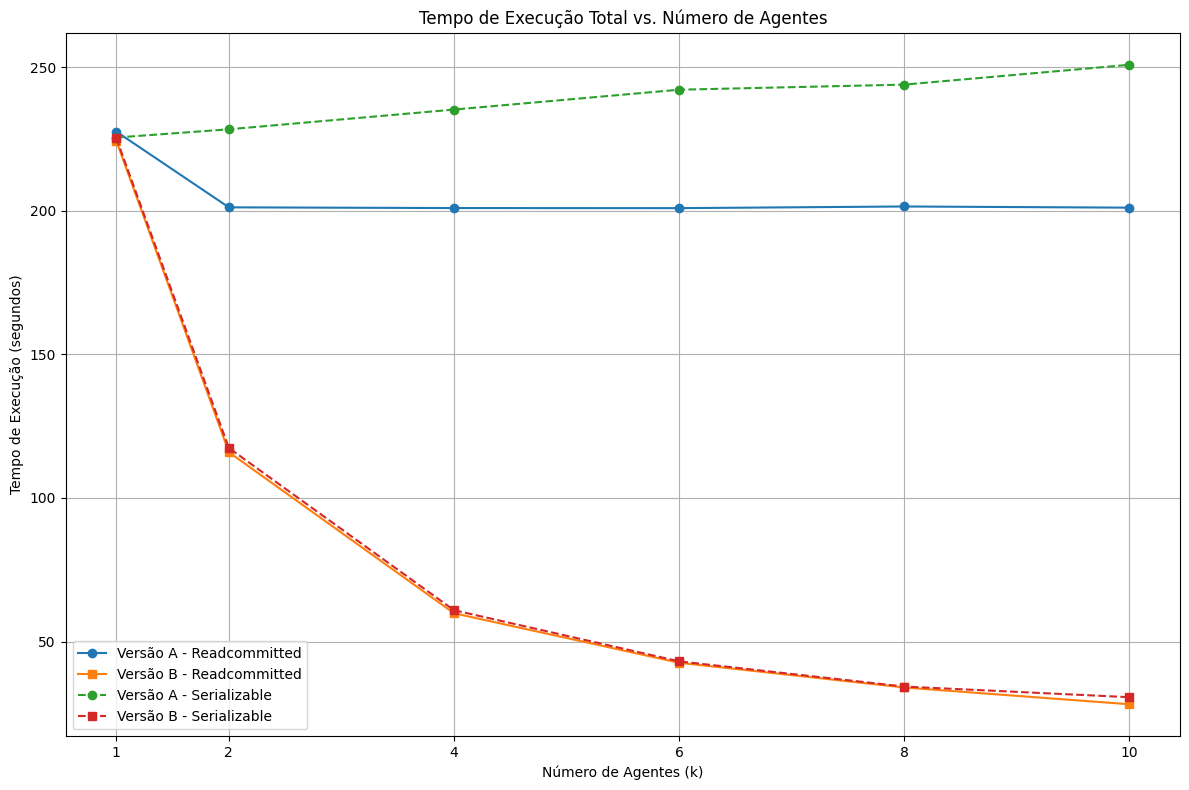

In [26]:
# --- Apresentação dos resultados para Tarefa 2, 3, 5 ---
print("\n" + "="*80)
print("--- RESULTADOS DA TAREFA 2 (Tempo de Execução) ---")
df_tempo = pd.DataFrame(results_tempo)
print(df_tempo.to_string())

plt.figure(figsize=(12, 8))
for iso_level in isolation_levels:
    for ver in versions:
        subset = df_tempo[(df_tempo['versao'] == ver) & (df_tempo['isolamento'] == iso_level)]
        label = f"Versão {ver} - {iso_level.replace(' ', '').title()}"
        marker = 'o' if ver == 'A' else 's'
        linestyle = '-' if iso_level == 'read committed' else '--'
        plt.plot(subset['agentes'], subset['duracao'], marker=marker, linestyle=linestyle, label=label)

plt.title('Tempo de Execução Total vs. Número de Agentes')
plt.xlabel('Número de Agentes (k)')
plt.ylabel('Tempo de Execução (segundos)')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print("="*80 + "\n")

### Tarefa 3

Apresente uma tabela com o número máximo, mínimo e médio de vezes que um cliente teve que tentar reservar um assento até conseguir, ou seja, o número de vezes que uma reserva teve que ser refeita. A tabela considera as variações de k, versão de reserva e nível de isolamento.


In [28]:
# Tarefa 3: Tabela de Tentativas por Reserva
print("\n--- Tabela de Tentativas por Reserva (Tarefa 3) ---")
df_tentativas = pd.DataFrame(results_tentativas)
# Agrupar por versão, agentes e isolamento para calcular min, max, avg
summary_tentativas = df_tentativas.groupby(['versao', 'agentes', 'isolamento'])['tentativas'].agg(['min', 'max', 'mean']).reset_index()
summary_tentativas.rename(columns={'mean': 'media'}, inplace=True)
print(summary_tentativas)


--- Tabela de Tentativas por Reserva (Tarefa 3) ---
   versao  agentes      isolamento  min  max  media
0       A        1  read committed    1    1  1.000
1       A        1    serializable    1    1  1.000
2       A        2  read committed    1    1  1.000
3       A        2    serializable    1   86  1.950
4       A        4  read committed    1    1  1.000
5       A        4    serializable    1  108  3.535
6       A        6  read committed    1    1  1.000
7       A        6    serializable    1  107  4.595
8       A        8  read committed    1    1  1.000
9       A        8    serializable    1  117  4.195
10      A       10  read committed    1    1  1.000
11      A       10    serializable    1  199  5.050
12      B        1  read committed    1    1  1.000
13      B        1    serializable    1    1  1.000
14      B        2  read committed    1    2  1.010
15      B        2    serializable    1    2  1.015
16      B        4  read committed    1    2  1.035
17      B  

### Tarefa 4

Apresente uma análise dos resultados obtidos em cada versão de reserva e tipo de isolamento, explicando as diferenças entre resultados.


### Tarefa 5

Análise de Conflitos de Concorrência. Para cada experimento executado, registre o número de deadlocks e rollbacks detectados pelo sistema gerenciador de banco de dados.

**O que entregar:** Um resumo tabular com o número total de deadlocks e rollbacks para cada combinação de (versão de reserva, nível de isolamento, valor de k). Indicação de como os erros foram tratados no código (ex: tentativas de reexecução, logs etc.).

In [29]:
# Tarefa 5: Resumo Tabular de Deadlocks e Rollbacks
print("\n--- Resumo de Deadlocks e Rollbacks (Tarefa 5) ---")
df_conflitos = pd.DataFrame(results_conflitos)
# Somar deadlocks e rollbacks por grupo
summary_conflitos = df_conflitos.groupby(['versao', 'agentes', 'isolamento'])[['deadlocks', 'rollbacks']].sum().reset_index()
print(summary_conflitos.to_string())
print("\nIndicação de como os erros foram tratados no código: Deadlocks e outros erros de psycopg2 são capturados com `try...except` e resultam em `conn.rollback()`. A thread então retenta a operação. Mensagens de log são impressas para cada ocorrência.")



--- Resumo de Deadlocks e Rollbacks (Tarefa 5) ---
   versao  agentes      isolamento  deadlocks  rollbacks
0       A        1  read committed          0          0
1       A        1    serializable          0          0
2       A        2  read committed          0          0
3       A        2    serializable          0        200
4       A        4  read committed          0          0
5       A        4    serializable          0        600
6       A        6  read committed          0          0
7       A        6    serializable          0       1000
8       A        8  read committed          0          0
9       A        8    serializable          0       1400
10      A       10  read committed          0          0
11      A       10    serializable          0       1799
12      B        1  read committed          0          0
13      B        1    serializable          0          0
14      B        2  read committed          0          4
15      B        2    serializable  

### Tarefa 6 - Avaliação de Variação na Ordem de Alocação de Assentos

Compare a ordem final dos assentos ocupados (i.e., a sequência de num_voo com disp = false) entre diferentes execuções de um mesmo cenário com concorrência (mesmo k, versão e nível de isolamento), para identificar variações causadas por condições de corrida.

**O que entregar:** Para cada combinação de parâmetros com k > 1, execute o experimento 3 vezes e apresente a variação na ordem dos assentos alocados; Discuta a relação dessa variação com o nível de isolamento e a estrutura transacional usada.



In [ ]:
"""
# Tarefa 6: Avaliação de Variação na Ordem de Alocação de Assentos
print("\n--- Variação na Ordem de Alocação de Assentos (Tarefa 6) ---")
df_ordem = pd.DataFrame(results_ordem_assentos)

# Para cada cenário (versao, agentes, isolamento) com k > 1, compare as 3 execuções
for (ver, k, iso_level), group in df_ordem.groupby(['versao', 'agentes', 'isolamento']):
    if k > 1:
        print(f"\nCenário: Versão={ver}, Agentes={k}, Isolamento={iso_level}")
        orders = group['ordem_final'].tolist()
        
        # Comparar as ordens
        if len(orders) == 3:
            # Converter para set para checar se os CONJUNTOS de assentos são os mesmos
            # e comparar as listas diretamente para a ORDEM
            set1 = set(orders[0])
            set2 = set(orders[1])
            set3 = set(orders[2])

            # Verifica se a quantidade de assentos reservados é a mesma
            if len(set1) == len(set2) == len(set3) == 200: # Assumindo 200 assentos totais
                print(f"  Todas as 3 execuções reservaram 200 assentos.")
            else:
                print(f"  AVISO: Nem todas as 3 execuções reservaram 200 assentos. Verifique logs.")

            # Compara a ordem das listas
            if orders[0] == orders[1] and orders[1] == orders[2]:
                print("  Ordem de alocação: IDÊNTICA nas 3 execuções.")
            else:
                print("  Ordem de alocação: VARIADA entre as 3 execuções.")
                # Opcional: imprimir as ordens para visualização
                # for i, order in enumerate(orders):
                #     print(f"    Execução {i+1}: {order[:10]}...") # Imprime os primeiros 10 para não poluir
        else:
            print(f"  Não há 3 execuções para comparar para este cenário (k={k}).")

"""


--- Variação na Ordem de Alocação de Assentos (Tarefa 6) ---


KeyError: 'versao'

### Tarefa 7 - Demonstração de Anomalias de Concorrência em Diferentes Níveis de Isolamento

O objetivo desta tarefa é observar experimentalmente a ocorrência (ou não) de três tipos clássicos de anomalias em transações concorrentes, sob os níveis de isolamento **READ COMMITTED** e **SERIALIZABLE**. Para isso, implemente três experimentos distintos e controlados, cada um projetado para testar um fenômeno. Cada experimento deve ser executado duas vezes, uma com cada nível de isolamento, e a diferença de comportamento deve ser registrada.



In [30]:
# --- Funções para Experimentos de Anomalias de Concorrência (Tarefa 7) ---

def run_anomaly_experiment(experiment_name, t1_func, t2_func, isolation_level):
    """
    Função auxiliar para rodar experimentos de anomalias com T1 e T2.
    """
    print(f"\n--- Executando Experimento: {experiment_name} (Isolamento: {isolation_level}) ---")
    
    # Eventos para sincronização entre T1 e T2
    t1_start_event = threading.Event()
    t2_start_event = threading.Event()
    t1_continue_event = threading.Event()
    t2_continue_event = threading.Event()
    
    t1_thread = threading.Thread(target=t1_func, args=(t1_start_event, t1_continue_event, t2_start_event, t2_continue_event, isolation_level))
    t2_thread = threading.Thread(target=t2_func, args=(t1_start_event, t1_continue_event, t2_start_event, t2_continue_event, isolation_level))

    t1_thread.start()
    t2_thread.start()

    t1_thread.join()
    t2_thread.join()
    print(f"--- Fim do Experimento: {experiment_name} ---")

In [31]:
# --- Tarefa 7: Demonstração de Anomalias de Concorrência ---
print("\n--- Iniciando Experimentos de Anomalias de Concorrência (Tarefa 7) ---")

# Limpar assentos antes de cada experimento de anomalia
limpar_assentos()


--- Iniciando Experimentos de Anomalias de Concorrência (Tarefa 7) ---
Todos os assentos foram limpos (definidos como TRUE).


#### Experimento A - Non-repeatable Read

**Descrição:** Uma transação lê um mesmo dado duas vezes, mas entre essas duas leituras, outra transação modifica o dado e realiza commit.

**Cenário:**
* T1 inicia e lê o valor de um assento específico.
* T2 inicia, atualiza o mesmo assento para reservado (disp=false) e comita.
* T1 tenta reler o mesmo assento.

**O que entregar:**
* Código das transações T1 e T2.
* Logs ou saídas indicando se T1 leu valores diferentes na primeira e segunda leitura.
* Análise: isso ocorreu em qual nível de isolamento?




In [32]:
# Experimento A: Non-repeatable Read
def t1_non_repeatable_read(t1_start, t1_continue, t2_start, t2_continue, isolation_level):
    conn = None
    try:
        conn = get_conexao_db(DB_CONFIG_OFICINA4, isolation_level=isolation_level)
        cur = conn.cursor()
        print(f"[T1-{isolation_level}]: Inicia transação.")

        # 1. T1 lê o valor de um assento específico (ex: assento 1)
        cur.execute("SELECT disp FROM Assentos WHERE num_voo = 1;")
        disp_t1_leitura1 = cur.fetchone()[0]
        print(f"[T1-{isolation_level}]: Primeira leitura do assento 1: disp = {disp_t1_leitura1}")

        # Sinaliza T2 para começar e espera T2 comitar
        t2_start.set()
        print(f"[T1-{isolation_level}]: Esperando T2 comitar...")
        t1_continue.wait() # Espera T2 sinalizar que comitou

        # 2. T1 tenta reler o mesmo assento
        cur.execute("SELECT disp FROM Assentos WHERE num_voo = 1;")
        disp_t1_leitura2 = cur.fetchone()[0]
        print(f"[T1-{isolation_level}]: Segunda leitura do assento 1: disp = {disp_t1_leitura2}")

        if disp_t1_leitura1 != disp_t1_leitura2:
            print(f"[T1-{isolation_level}]: *** Anomalia Non-repeatable Read detectada! ***")
        else:
            print(f"[T1-{isolation_level}]: Non-repeatable Read NÃO detectada.")
        
        conn.commit()
    except Exception as e:
        print(f"[T1-{isolation_level}]: Erro: {e}")
        if conn: conn.rollback()
    finally:
        if conn: conn.close()

def t2_non_repeatable_read(t1_start, t1_continue, t2_start, t2_continue, isolation_level):
    conn = None
    try:
        # Espera T1 ler primeiro
        t2_start.wait()
        conn = get_conexao_db(DB_CONFIG_OFICINA4, isolation_level=isolation_level)
        cur = conn.cursor()
        print(f"[T2-{isolation_level}]: Inicia transação.")

        # T2 atualiza o mesmo assento para reservado (disp=false) e comita
        cur.execute("UPDATE Assentos SET disp = FALSE WHERE num_voo = 1;")
        conn.commit()
        print(f"[T2-{isolation_level}]: Assento 1 atualizado para disp=FALSE e comitado.")
        
        # Sinaliza T1 para continuar
        t1_continue.set()
    except Exception as e:
        print(f"[T2-{isolation_level}]: Erro: {e}")
        if conn: conn.rollback()
    finally:
        if conn: conn.close()


In [33]:
# Experimento A: Non-repeatable Read
for iso_level in isolation_levels:
    # Resetar assento 1 para TRUE antes de cada execução do experimento A
    conn_reset = get_conexao_db(DB_CONFIG_OFICINA4)
    cur_reset = conn_reset.cursor()
    cur_reset.execute("UPDATE Assentos SET disp = TRUE WHERE num_voo = 1;")
    conn_reset.commit()
    cur_reset.close()
    conn_reset.close()

    run_anomaly_experiment("Non-repeatable Read", t1_non_repeatable_read, t2_non_repeatable_read, iso_level)


--- Executando Experimento: Non-repeatable Read (Isolamento: read committed) ---
[T1-read committed]: Inicia transação.
[T1-read committed]: Primeira leitura do assento 1: disp = True
[T1-read committed]: Esperando T2 comitar...
[T2-read committed]: Inicia transação.
[T2-read committed]: Assento 1 atualizado para disp=FALSE e comitado.
[T1-read committed]: Segunda leitura do assento 1: disp = False
[T1-read committed]: *** Anomalia Non-repeatable Read detectada! ***
--- Fim do Experimento: Non-repeatable Read ---

--- Executando Experimento: Non-repeatable Read (Isolamento: serializable) ---
[T1-serializable]: Inicia transação.
[T1-serializable]: Primeira leitura do assento 1: disp = True
[T1-serializable]: Esperando T2 comitar...
[T2-serializable]: Inicia transação.
[T2-serializable]: Assento 1 atualizado para disp=FALSE e comitado.
[T1-serializable]: Segunda leitura do assento 1: disp = True
[T1-serializable]: Non-repeatable Read NÃO detectada.
--- Fim do Experimento: Non-repeatable

#### Experimento B - Phanton Read

**Descrição:** Uma transação executa a mesma consulta duas vezes e obtém conjuntos de resultados diferentes porque outra transação inseriu ou removeu dados que se encaixam no critério da consulta.

**Cenário:**
* T1 inicia e consulta todos os assentos vagos (disp=true).
* T2 inicia, insere um novo assento vago (disp=true) ou atualiza um assento para vago, e comita.
* T1 executa novamente a mesma consulta.


**O que entregar:**
* Código de T1 e T2.
* Saída das duas execuções da consulta de T1.
* Indicação se houve alteração no resultado.
* Discussão da relação com o nível de isolamento usado.


In [34]:
# Experimento B: Phantom Read
def t1_phantom_read(t1_start, t1_continue, t2_start, t2_continue, isolation_level):
    conn = None
    try:
        conn = get_conexao_db(DB_CONFIG_OFICINA4, isolation_level=isolation_level)
        cur = conn.cursor()
        print(f"[T1-{isolation_level}]: Inicia transação.")

        # 1. T1 consulta todos os assentos vagos
        cur.execute("SELECT num_voo FROM Assentos WHERE disp = TRUE ORDER BY num_voo;")
        assentos_t1_leitura1 = [row[0] for row in cur.fetchall()]
        print(f"[T1-{isolation_level}]: Primeira consulta de assentos vagos: {len(assentos_t1_leitura1)} assentos.")

        # Sinaliza T2 para começar e espera T2 comitar
        t2_start.set()
        print(f"[T1-{isolation_level}]: Esperando T2 inserir/atualizar e comitar...")
        t1_continue.wait() # Espera T2 sinalizar que comitou

        # 2. T1 executa novamente a mesma consulta
        cur.execute("SELECT num_voo FROM Assentos WHERE disp = TRUE ORDER BY num_voo;")
        assentos_t1_leitura2 = [row[0] for row in cur.fetchall()]
        print(f"[T1-{isolation_level}]: Segunda consulta de assentos vagos: {len(assentos_t1_leitura2)} assentos.")

        if len(assentos_t1_leitura1) != len(assentos_t1_leitura2):
            print(f"[T1-{isolation_level}]: *** Anomalia Phantom Read detectada! ***")
            print(f"   Diferença: {len(assentos_t1_leitura2) - len(assentos_t1_leitura1)} novos/removidos assentos.")
        else:
            print(f"[T1-{isolation_level}]: Phantom Read NÃO detectada.")
        
        conn.commit()
    except Exception as e:
        print(f"[T1-{isolation_level}]: Erro: {e}")
        if conn: conn.rollback()
    finally:
        if conn: conn.close()

def t2_phantom_read(t1_start, t1_continue, t2_start, t2_continue, isolation_level):
    conn = None
    try:
        # Espera T1 ler primeiro
        t2_start.wait()
        conn = get_conexao_db(DB_CONFIG_OFICINA4, isolation_level=isolation_level)
        conn.autocommit = False # Para garantir transação
        cur = conn.cursor()
        print(f"[T2-{isolation_level}]: Inicia transação.")

        # T2 insere um novo assento vago (ou atualiza um existente para vago) e comita
        # Vamos inserir um novo assento para garantir o "phantom"
        cur.execute("INSERT INTO Assentos (num_voo, disp) VALUES (201, TRUE) ON CONFLICT (num_voo) DO UPDATE SET disp = TRUE;")
        conn.commit()
        print(f"[T2-{isolation_level}]: Assento 201 inserido/atualizado para disp=TRUE e comitado.")
        
        # Sinaliza T1 para continuar
        t1_continue.set()
    except Exception as e:
        print(f"[T2-{isolation_level}]: Erro: {e}")
        if conn: conn.rollback()
    finally:
        if conn: conn.close()
        # Limpar o assento 201 para não afetar outros testes
        conn_cleanup = get_conexao_db(DB_CONFIG_OFICINA4)
        conn_cleanup.autocommit = True
        cur_cleanup = conn_cleanup.cursor()
        cur_cleanup.execute("DELETE FROM Assentos WHERE num_voo = 201;")
        conn_cleanup.close()

In [ ]:
# Experimento B: Phantom Read
for iso_level in isolation_levels:
    # Resetar assentos (e garantir que 201 não exista) antes de cada execução do experimento B
    limpar_assentos() # Isso também remove o assento 201 se ele foi inserido
    run_anomaly_experiment("Phantom Read", t1_phantom_read, t2_phantom_read, iso_level)

Todos os assentos foram limpos (definidos como TRUE).

--- Executando Experimento: Phantom Read (Isolamento: read committed) ---
[T1-read committed]: Inicia transação.
[T1-read committed]: Primeira consulta de assentos vagos: 200 assentos.
[T1-read committed]: Esperando T2 inserir/atualizar e comitar...
[T2-read committed]: Inicia transação.
[T2-read committed]: Erro: ERRO:  a nova linha da relação "assentos" viola a restrição de verificação "assentos_num_voo_check"
DETAIL:  Registro que falhou contém (201, t).



#### Experimento C - Dirty Read

**Descrição:** Uma transação lê dados modificados por outra transação que ainda não fez commit (ou que foi revertida). Esse experimento serve para mostrar que o PostgreSQL não permite dirty reads nem mesmo em READ COMMITTED, então o comportamento esperado é que não ocorra a leitura suja.

**Cenário:**
* T1 inicia e atualiza o valor de um assento (disp=false), mas não comita.
* T2 inicia e tenta ler o mesmo assento.
* T1 faz rollback.


**O que entregar:**
* Código de T1 e T2 com sincronização apropriada para simular esse cenário.
* Comprovação de que T2 não teve acesso ao valor não confirmado.
* Discussão: por que isso ocorre mesmo em READ COMMITTED?

In [ ]:
# Experimento C: Dirty Read (PostgreSQL não permite)
def t1_dirty_read(t1_start, t1_continue, t2_start, t2_continue, isolation_level):
    conn = None
    try:
        conn = get_conexao_db(DB_CONFIG_OFICINA4, isolation_level=isolation_level)
        cur = conn.cursor()
        print(f"[T1-{isolation_level}]: Inicia transação.")

        # T1 atualiza o valor de um assento (disp=false), mas não comita
        cur.execute("UPDATE Assentos SET disp = FALSE WHERE num_voo = 2;")
        print(f"[T1-{isolation_level}]: Assento 2 atualizado para disp=FALSE, mas NÃO comitado.")

        # Sinaliza T2 para tentar ler e espera T2 tentar ler
        t2_start.set()
        print(f"[T1-{isolation_level}]: Esperando T2 tentar ler...")
        t1_continue.wait() # Espera T2 sinalizar que tentou ler

        # T1 faz rollback
        conn.rollback()
        print(f"[T1-{isolation_level}]: T1 fez rollback. Assento 2 deve voltar a TRUE.")
        
        t2_continue.set() # Sinaliza T2 para continuar (se estiver esperando)
    except Exception as e:
        print(f"[T1-{isolation_level}]: Erro: {e}")
        if conn: conn.rollback()
    finally:
        if conn: conn.close()

def t2_dirty_read(t1_start, t1_continue, t2_start, t2_continue, isolation_level):
    conn = None
    try:
        # Espera T1 atualizar e não comitar
        t2_start.wait()
        conn = get_conexao_db(DB_CONFIG_OFICINA4, isolation_level=isolation_level)
        cur = conn.cursor()
        print(f"[T2-{isolation_level}]: Inicia transação.")

        # T2 tenta ler o mesmo assento
        print(f"[T2-{isolation_level}]: Tentando ler o assento 2 (modificado por T1, não comitado)...")
        cur.execute("SELECT disp FROM Assentos WHERE num_voo = 2;")
        disp_t2 = cur.fetchone()[0]
        print(f"[T2-{isolation_level}]: T2 leu assento 2: disp = {disp_t2}")

        if disp_t2 == False:
            print(f"[T2-{isolation_level}]: *** Anomalia Dirty Read DETECTADA (inesperado no PG)! ***")
        else:
            print(f"[T2-{isolation_level}]: Dirty Read NÃO detectada. T2 leu o valor original (TRUE).")
        
        conn.commit() # T2 comita sua leitura
        t1_continue.set() # Sinaliza T1 para continuar (fazer rollback)
        t2_continue.wait() # Espera T1 sinalizar que fez rollback para garantir que o estado final seja visto
    except Exception as e:
        print(f"[T2-{isolation_level}]: Erro: {e}")
        if conn: conn.rollback()
    finally:
        if conn: conn.close()


In [ ]:
# Experimento C: Dirty Read
for iso_level in isolation_levels:
    # Resetar assento 2 para TRUE antes de cada execução do experimento C
    conn_reset = get_conexao_db(DB_CONFIG_OFICINA4)
    cur_reset = conn_reset.cursor()
    cur_reset.execute("UPDATE Assentos SET disp = TRUE WHERE num_voo = 2;")
    conn_reset.commit()
    cur_reset.close()
    conn_reset.close()

    run_anomaly_experiment("Dirty Read", t1_dirty_read, t2_dirty_read, iso_level)